In [ ]:
# Step 1: Install required packages
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib scipy scikit-image --quiet

# Step 2: Clone the DINO repository
!git clone https://github.com/facebookresearch/dino


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.2 MB/s eta 0:00:00
Cloning into 'dino'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175 (from 1)
Receiving objects: 100% (175/175), 24.47 MiB | 34.75 MiB/s, done.


In [ ]:
import torch
import torchvision.transforms as T
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2
import os

# Change working directory to DINO
os.chdir("dino")


In [ ]:
# Load pretrained ViT-S/8 model
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
model.eval()


Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 202MB/s]


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

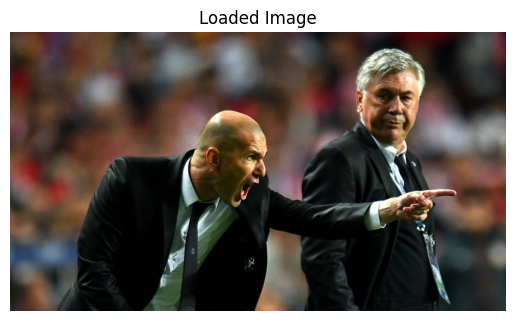

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# ✅ This image works perfectly
img_url = "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/zidane.jpg"
response = requests.get(img_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

# Show image
plt.imshow(image)
plt.axis("off")
plt.title("Loaded Image")
plt.show()


Saving animal.jpg to animal.jpg


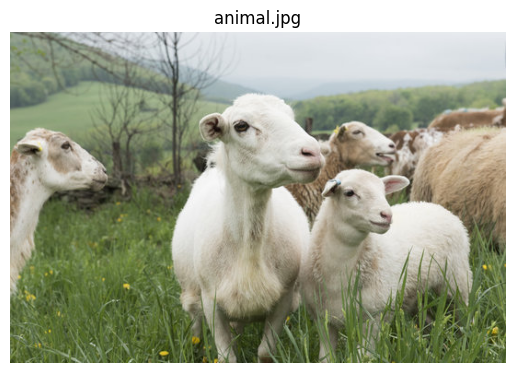

In [ ]:
from google.colab import files
uploaded = files.upload()

# Load uploaded image
image_path = list(uploaded.keys())[0]
image = Image.open(image_path).convert("RGB")

# Show image
plt.imshow(image)
plt.axis("off")
plt.title("Your Uploaded Image")
plt.show()


In [ ]:
from torchvision.ops import box_convert
import cv2

def get_bounding_boxes(attn_map, image_size, threshold=0.6):
    """
    Converts attention map to bounding boxes
    """
    attn_map = attn_map.reshape(14, 14).detach().numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
    mask = attn_map > threshold

    if mask.sum() == 0:
        return []

    coords = np.argwhere(mask)
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    h, w = image_size
    scale_x, scale_y = w / 14, h / 14

    return [(int(x_min * scale_x), int(y_min * scale_y), int((x_max - x_min) * scale_x), int((y_max - y_min) * scale_y))]


In [ ]:
def draw_boxes(image, boxes):
    image_with_box = np.array(image).copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue box
    return Image.fromarray(image_with_box)


In [ ]:
# Pick one head (say head 0)
head = 0
attn_map = attn[head, 0, 1:]

# Get bounding box
boxes = get_bounding_boxes(attn_map, image.size, threshold=0.6)

# Draw boxes
image_with_box = draw_boxes(image, boxes)

# Show final image
plt.imshow(image_with_box)
plt.axis("off")
plt.title("Object Localization via DINO")
plt.show()


NameError: name 'attn' is not defined

In [11]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 35.3 MB/s eta 0:00:00


In [12]:
# STEP 1: Install required libraries
!pip install -q ultralytics gradio

# STEP 2: Import libraries
from ultralytics import YOLO
import gradio as gr
import cv2
import numpy as np
from PIL import Image

# STEP 3: Load YOLOv8 model (use 'yolov8l.pt' or 'yolov8n.pt' for speed)
model = YOLO('yolov8l.pt')  # Download automatically if not present

# STEP 4: Inference + visualization function
def detect_objects(image):
    image = Image.fromarray(image)
    results = model(image)  # Run inference
    result_img = results[0].plot()  # Draw bounding boxes
    return Image.fromarray(result_img)

# STEP 5: Gradio Interface
interface = gr.Interface(
    fn=detect_objects,
    inputs=gr.Image(type="numpy", label="Upload Image"),
    outputs=gr.Image(type="pil", label="Detected Image"),
    title="Multiple Object Localization with YOLOv8",
    description="Upload an image and YOLOv8 will localize and draw bounding boxes around all detected objects."
)

# STEP 6: Launch App
interface.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 83.7M/83.7M [00:00<00:00, 143MB/s]


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2b537b26bad71ac4c2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [13]:
from ultralytics import YOLO
import gradio as gr
import cv2
import numpy as np
from PIL import Image

model = YOLO("yolov8l.pt")

def detect_without_labels(image):
    # Run detection
    results = model(image)
    result = results[0]

    # Convert to OpenCV image
    image_np = np.array(image)
    if image_np.shape[-1] == 4:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)

    # Draw bounding boxes without labels
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(image_np, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box

    return Image.fromarray(image_np)

interface = gr.Interface(
    fn=detect_without_labels,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=gr.Image(type="pil", label="Detected Image (No Labels)"),
    title="YOLOv8 Object Detection",
    description="Upload an image — bounding boxes will be drawn without class names or confidence scores."
)

interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eb6a28d416fad4ca1d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
